# Produce a Convolutional Neural Network that can distinuish between different Seal Vocalisations

We have produced 563 npz files of spectrogram data for different seal vocalisation data. 

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil  
import random 


2025-01-12 21:35:47.328462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 21:35:48.439810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 21:35:48.761974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 21:35:51.195744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 21:35:56.420748: W tensorflow/compiler/tf2

In [2]:
# function to load the npz files

folder_path = 'data/processed/NPZ_files'
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npz')]

# create x and y arrays. x being the spectorgram and y being the call annotation
x = []
y = []

for file in files:
    npz_data = np.load(file)
    spectrogram = npz_data['spectrogram']
    call = npz_data['annotation']
    
    x.append(spectrogram)
    y.append(call)

x = np.array(x)
y = np.array(y)

x.shape
#y.shape

(563, 1025, 561)

The shape of our data is (563, 1025, 56). This represents dimensions for number of samples, frequency bins and time steps. 

563 - the number of files we have

1025 - The frequency axis has been split into 1025 different bins. This is decided based on the nfft you choose. We used 2048. The formula[[1]](https://dsp.stackexchange.com/questions/26927/what-is-a-frequency-bin) used is nfft-2+1.

561 - the x axis has been split into frames and is related to the nover used when generating the spectrograms[[2]](https://stackoverflow.com/questions/64136637/time-steps-difference-in-spectrogram). 

Our data is only 3D, it doesnt have a channel dimension. CNN's require a 4D shape[[3]](https://stackoverflow.com/questions/60157742/convolutional-neural-network-cnn-input-shape). We need to add a channel dimension to our data. As the training will be done on grayscale spectrograms, we will add a channel dimension of 1.

In [3]:
# Add a channel dimension to the data
x = np.expand_dims(x, axis=-1)  # Shape becomes (480, 1025, 561, 1)
x.shape

(563, 1025, 561, 1)

A greyscale will have an array between 0 and 1. We need to check what ours are.

In [4]:
min_value = x.min()
max_value = x.max()

print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")

Minimum value: 7.733122287834104e-17
Maximum value: 97.88693237304688


As our images are not greyscale at the moment we need to carry out some normalisation before using the Neural Network.

In [5]:
# Normalise to [0, 1]

x = x / max_value

new_min_value = x.min()
new_max_value = x.max()
print(f"Minimum value: {new_min_value}")
print(f"Maximum value: {new_max_value}")

Minimum value: 7.900055648612461e-19
Maximum value: 1.0


Now our data is in the range [0,1]

In [6]:
# Checking how many calls are present in our dataset 

number_of_calls = np.unique(y).size
number_of_calls

3

We have 3 different calls in our dataset of 563. If its unabalanced it will be harder to train the model. 

In [7]:
Counter(y)

Counter({'Rupe A': 342, 'Rupe B': 121, 'Non call': 100})

There are 342 Rupe A calls, 121 Rupe B and 100 Non-calls. This is a slightly unbalanced dataset and could lead to the model having a bias for Rupe A due to the overrepresentation in the training set. 

## Data augmentation


In [8]:
#Data augmentation

# Folder containing your .npz files
data_folder = "data/processed/NPZ_files"
output_folder = "data/processed/Data_augmentation"

# Create output directories for filtered classes
os.makedirs(os.path.join(output_folder, "Rupe_B"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "Non_Call"), exist_ok=True)

# Filter files by class
rupe_b_files = []
non_call_files = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        if "_Rupe_B" in file:
            rupe_b_files.append(file)
        elif "_Non_call" in file:
            non_call_files.append(file)


In [9]:
def augment_npz(file_path, output_dir, augment_count=2):
    base_name = os.path.basename(file_path).split('.')[0]
    data = np.load(file_path)

    # Assuming the main array is named 'arr_0'
    array = data['spectrogram']

    # Preserve other arrays
    metadata = {key: data[key] for key in data.files if key != 'spectrogram'}

    # Perform augmentations
    for i in range(augment_count):
        augmented_spectrogram = spectrogram

        # Apply random augmentation
        if random.random() > 0.5:
            augmented_spectrogram = spectrogram + np.random.normal(0, 0.01, spectrogram.shape)  # Add noise
        else:
            augmented_spectrogram = np.flip(spectrogram, axis=1)  # Flip along frequency axis

        # Save augmented data
        output_file_name = f"{os.path.basename(file_path).replace('.npz', '')}_aug_{i}.npz"
        output_path = os.path.join(output_dir, output_file_name)
        np.savez_compressed(output_path, spectrogram=augmented_spectrogram, **metadata)


# Filter files for specific classes
rupe_b_files = [f for f in os.listdir(data_folder) if "_Rupe_B" in f]
non_call_files = [f for f in os.listdir(data_folder) if "_Non_call" in f]

for file in rupe_b_files:
    augment_npz(
        file_path=os.path.join(data_folder, file),
        output_dir=os.path.join(output_folder, "Rupe_B")  # Save in 'Rupe_B' subfolder
    )

# Augment 'Non_Call' and save to its specific folder
for file in non_call_files:
    augment_npz(
        file_path=os.path.join(data_folder, file),
        output_dir=os.path.join(output_folder, "Non_Call")  # Save in 'Non_Call' subfolder
    )

print("Augmentation completed!")

Augmentation completed!


Now to bring hte data all together.

In [10]:
# Define paths
original_data_folder = "data/processed/NPZ_files"
augmentation_folder = "data/processed/Data_augmentation"
combined_folder = "data/processed/combined_dataset"

# Create combined dataset folder and class subfolders
#os.makedirs(os.path.join(combined_folder, "Non_Call"), exist_ok=True)
#os.makedirs(os.path.join(combined_folder, "Rupe_B"), exist_ok=True)
#os.makedirs(os.path.join(combined_folder, "Rupe_A"), exist_ok=True)

# Move augmented Non_Call files
for file in os.listdir(os.path.join(augmentation_folder, "Non_Call")):
    shutil.copy(
        os.path.join(augmentation_folder, "Non_Call", file),
        os.path.join(combined_folder)
    )

# Move augmented Rupe_B files
for file in os.listdir(os.path.join(augmentation_folder, "Rupe_B")):
    shutil.copy(
        os.path.join(augmentation_folder, "Rupe_B", file),
        os.path.join(combined_folder)
    )

# Copy original files if they are separate from augmented data
for file in os.listdir(original_data_folder):
    if "_Non_call" in file:
        shutil.copy(
            os.path.join(original_data_folder, file),
            os.path.join(combined_folder)
        )
    elif "_Rupe_B" in file:
        shutil.copy(
            os.path.join(original_data_folder, file),
            os.path.join(combined_folder)
        )
    elif "_Rupe_A" in file:
        shutil.copy(
            os.path.join(original_data_folder, file),
            os.path.join(combined_folder)
        )

In [11]:
# function to load the npz files

folder_path = 'data/processed/combined_dataset'
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npz')]

# create x and y arrays. x being the spectorgram and y being the call annotation
x = []
y = []

for file in files:
    npz_data = np.load(file)
    spectrogram = npz_data['spectrogram']
    call = npz_data['annotation']
    
    x.append(spectrogram)
    y.append(call)

x = np.array(x)
y = np.array(y)

x.shape
#y.shape

(1005, 1025, 561)

In [12]:
Counter(y)

Counter({'Rupe B': 363, 'Rupe A': 342, 'Non call': 300})

The dataset is now much more balanced.

We need to make it 4D for the Convolutional Neural Network models

In [13]:
# Add a channel dimension to the data
x = np.expand_dims(x, axis=-1)  # Shape becomes (480, 1025, 561, 1)
x.shape

(1005, 1025, 561, 1)

In [14]:
#Confirm its not greyscale
min_value = x.min()
max_value = x.max()

print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")


Minimum value: -0.05700925794693056
Maximum value: 97.88693237304688


In [15]:
# Normalise to [0, 1]

x = x / max_value

new_min_value = x.min()
new_max_value = x.max()
print(f"Minimum value: {new_min_value}")
print(f"Maximum value: {new_max_value}")

Minimum value: -0.0005823990655838352
Maximum value: 1.0


In [24]:
# checking its what we expect
number_of_classes = np.unique(y).size
x.shape, y.shape, number_of_classes

((1005, 1025, 561, 1), (1005,), 3)

Now we have 1005 samples between just 3 classes.

Next we will encode our labels and split our data into test and train groups. 

Neural networks require input and output variable to be numbers[[6]](https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/). 
``label_encoder`` and ``encoded_labels`` convert our calls (Rupe A/B) into integers (0/1). One hot encoding, via ``categorical_labels``, then converts this to a binary vector ``[0,0, 1]`` or ``[0, 1,0]`` or ``[1,0,0]``.

In [25]:

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)
categorical_labels = to_categorical(encoded_labels)


X_train, X_test, y_train, y_test = train_test_split(x, categorical_labels, random_state=42)


The plan was to have an extra Convolutional layer and use a Flatten layer, however this was proving to be computationally demanding for my laptop, so I used ``GlobalAveragePooling`` instead.

In [26]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1025, 561, 1)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.GlobalAveragePooling2D())  # Replace Flatten
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(number_of_classes, activation='softmax'))

2025-01-12 21:50:31.913550: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1025, 561, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 512, 280, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 280, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 256, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,107 (27.76 KB)

 Trainable params: 7,107 (27.76 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  #USed CategoricalCrossentropy as classes are one-hot encoded
    metrics=['accuracy'],
)

In [29]:
history = model.fit(X_train, y_train, epochs=25, validation_split=0.2)

Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.3622 - loss: 1.0978 - val_accuracy: 0.3245 - val_loss: 1.0994
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.3385 - loss: 1.0949 - val_accuracy: 0.3444 - val_loss: 1.1009
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.3275 - loss: 1.0954 - val_accuracy: 0.3245 - val_loss: 1.1021
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.3614 - loss: 1.0918 - val_accuracy: 0.3444 - val_loss: 1.1036
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.3436 - loss: 1.0966 - val_accuracy: 0.3444 - val_loss: 1.1034
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.3816 - loss: 1.0852 - val_accuracy: 0.3444 - val_loss: 1.1052
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.3759 - loss: 1.0925 - val_accuracy: 0.3444 - val_loss: 1.1026
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.3351 - loss: 1.0900 - val_accuracy: 0.3444 - val_loss:

The scores for this arent great, however the training loss does decrease as it runs through epoch, achieving a best score of 0.5237 at epoch 24. The best validation loss is actually at epoch 2 but it doesnt vary much throughout.  

In [30]:
model.evaluate(X_test, y_test, return_dict=True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - accuracy: 0.3656 - loss: 1.1034


{'accuracy': 0.369047611951828, 'loss': 1.1006982326507568}

In [31]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

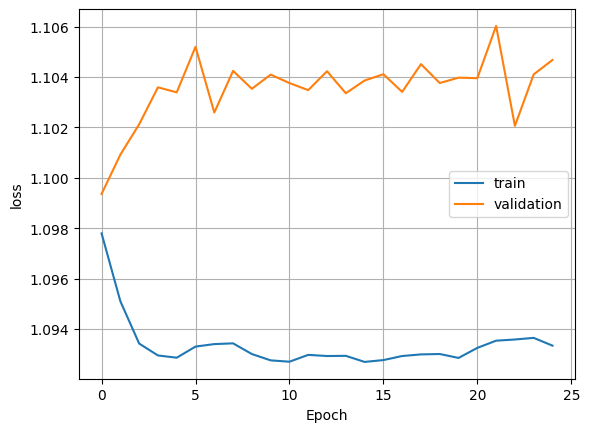

In [32]:
plot_loss(history)

In [34]:
for cls in unique_classes:
    class_indices = np.where(y == cls)
    class_data = x[class_indices]
    print(f"Class {cls}:")
    print(f"  Min: {class_data.min()}, Max: {class_data.max()}")
    print(f"  Mean: {class_data.mean():.10f}, Std Dev: {class_data.std():.10f}")
    print(f"  Shape: {class_data.shape}")

Class Non call:
  Min: -0.0005684685617182988, Max: 1.0
  Mean: 0.0000039791, Std Dev: 0.0002191917
  Shape: (300, 1025, 561, 1)
Class Rupe A:
  Min: 7.900055809659243e-19, Max: 0.509844362956379
  Mean: 0.0000046394, Std Dev: 0.0002383555
  Shape: (342, 1025, 561, 1)
Class Rupe B:
  Min: -0.0005823990655838352, Max: 0.5059222605102509
  Mean: 0.0000048686, Std Dev: 0.0002774975
  Shape: (363, 1025, 561, 1)


In [35]:
# Filter the dataset to only include Rupe A and Rupe B
selected_calls = ['Rupe A', 'Non call']

# Filter the dataset
indices = [i for i, label in enumerate(y) if label in selected_calls]
x_filtered = x[indices]
y_filtered = y[indices]

In [36]:
# checking its what we expect
number_of_classes = np.unique(y_filtered).size
x_filtered.shape, y_filtered.shape, number_of_classes

((642, 1025, 561, 1), (642,), 2)

In [41]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_filtered)
categorical_labels = to_categorical(encoded_labels)


X_train, X_test, y_train, y_test = train_test_split(x_filtered, categorical_labels, random_state=42)

In [ ]:
model2 = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(1025, 561, 1)),  # Input shape matches your spectrogram data
    MaxPooling2D((2, 2)),  # Downsample by 2x2
    Dropout(0.2),  # Prevent overfitting

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Flatten and Fully Connected Layers
    Flatten(),  # Flatten the 2D feature maps into 1D
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Prevent overfitting
    Dense(2, activation='softmax')  # Output layer for 2 classes
])

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
model2.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 1023, 559, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 511, 279, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 511, 279, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 509, 277, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 254, 138, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 254, 138, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2243328)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │   287,146,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,165,186 (1.07 GB)

 Trainable params: 287,165,186 (1.07 GB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model2.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20,  # Adjust based on performance
                    batch_size=32)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.4971 - loss: 0.6951 - val_accuracy: 0.5404 - val_loss: 0.6913
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.4768 - loss: 0.6961 - val_accuracy: 0.5404 - val_loss: 0.6856
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.5554 - loss: 0.6857 - val_accuracy: 0.5280 - val_loss: 0.6729
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.5113 - loss: 0.6908 - val_accuracy: 0.5404 - val_loss: 0.6459
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.5369 - loss: 0.6490 - val_accuracy: 0.5404 - val_loss: 0.6389
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.5369 - loss: 0.6397 - val_accuracy: 0.5404 - val_loss: 0.6499
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.5321 - loss: 0.6378 - val_accuracy: 0.5714 - val_loss: 0.6334
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.5659 - loss: 0.6224 - val_accuracy: 0.5342 - val_loss:

In [54]:
model2.evaluate(X_test, y_test, return_dict=True)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 739ms/step - accuracy: 0.5702 - loss: 0.6238


{'accuracy': 0.5838509202003479, 'loss': 0.6204264760017395}

Again, this model is performing terribly. There must be wrong with the data that has been processed for it. When reviewing the orignal data uploaded from the npz files, the range of values for the Non_call is huge.

In [60]:

folder_path = 'data/processed/NPZ_files'
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npz')]

# create x and y arrays. x being the spectorgram and y being the call annotation
x2 = []
y2 = []

for file in files:
    npz_data = np.load(file)
    spectrogram = npz_data['spectrogram']
    call = npz_data['annotation']
    
    x2.append(spectrogram)
    y2.append(call)

x2 = np.array(x2)
y2 = np.array(y2)

min_value = x2.min()
max_value = x2.max()

print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")

Minimum value: 7.733122287834104e-17
Maximum value: 97.88693237304688


As this range (7.733122287834104e-17 - 97.89) is so big, when the normalisaton takes place it shrinks all other values to almost zero. It could be down to this over-normalisation and the CNN models are having difficulty finding meaningful variations. To avoid this we will disregard Non-calls and just look at the Rupes.

In [ ]:
folder_path = 'data/processed/NPZ_files'
rupe_files = [
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.endswith('.npz') and ('Rupe_A' in f or 'Rupe_B' in f)
]

# create x and y arrays. x being the spectorgram and y being the call annotation
rupe_x = []
rupe_y = []

for file in rupe_files:
    npz_data = np.load(file)
    spectrogram = npz_data['spectrogram']
    call = npz_data['annotation']
    
    rupe_x.append(spectrogram)
    rupe_y.append(call)

rupe_x = np.array(rupe_x)
rupe_y = np.array(rupe_y)

In [61]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(rupe_y)
categorical_labels = to_categorical(encoded_labels)


X_train, X_test, y_train, y_test = train_test_split(rupe_x, categorical_labels, random_state=42)

In [24]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [25]:
model2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1025, 561, 1)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax')])

In [ ]:
model2.summary()

In [26]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [27]:
history = model2.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100


2025-01-11 00:43:21.358361: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
W0000 00:00:1736556202.928939   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556202.982570   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556202.997684   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556203.015541   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556203.033395   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556203.055542   18436 gpu_timer.cc:114] Skipping the delay kernel, measureme

8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7045 - loss: 0.7740

W0000 00:00:1736556210.249184   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556210.254145   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556210.259091   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556210.264943   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556210.270800   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556210.278787   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556210.288877   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556210.298654   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556210.309409   18436 gp

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.7064 - loss: 0.7689

W0000 00:00:1736556212.411118   18440 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.014198   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.016268   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.018292   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.020611   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.022929   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.025322   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.028481   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.031539   18438 gp

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 755ms/step - accuracy: 0.7080 - loss: 0.7649 - val_accuracy: 0.7143 - val_loss: 0.6032
Epoch 2/100


W0000 00:00:1736556213.215380   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.217828   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.220543   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.223702   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.227019   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.230924   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.235037   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.239832   18438 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556213.244945   18438 gp

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - accuracy: 0.7325 - loss: 0.5851 - val_accuracy: 0.7143 - val_loss: 0.6044
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.7641 - loss: 0.5659 - val_accuracy: 0.7143 - val_loss: 0.6111
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.7009 - loss: 0.6235 - val_accuracy: 0.7143 - val_loss: 0.6370
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.7248 - loss: 0.6276 - val_accuracy: 0.7143 - val_loss: 0.6149
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.7549 - loss: 0.5844 - val_accuracy: 0.7143 - val_loss: 0.6080
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.7242 - loss: 0.5985 - val_accuracy: 0.7143 - val_loss: 0.5994
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.8021 - loss: 0.5384 - val_accuracy: 0.7143 - val_loss: 0.5999
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.7548 - loss: 0.5942 - val_accuracy: 0.7143 - val_loss: 0.6

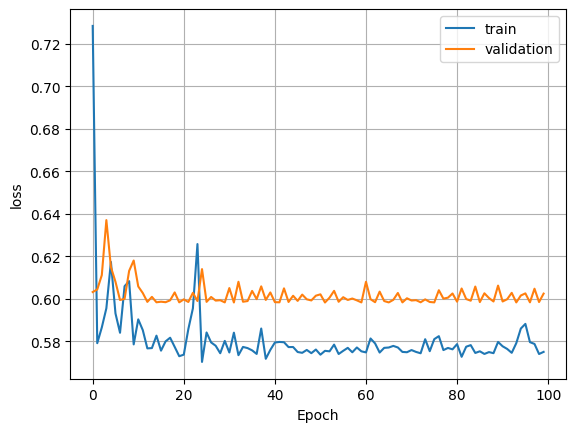

In [28]:
plot_loss(history)

In [29]:
model2.evaluate(X_test, y_test, return_dict=True)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7639 - loss: 0.5467

W0000 00:00:1736556585.385875   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556585.391979   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556585.398018   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556585.405177   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556585.412352   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556585.420950   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556585.431353   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556585.440744   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556585.450815   18436 gp

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.7583 - loss: 0.5530


W0000 00:00:1736556585.996646   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556586.004121   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556586.012519   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556586.022411   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556586.032969   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556586.045137   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556586.058084   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736556586.074240   18436 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


{'accuracy': 0.75, 'loss': 0.5623587965965271}

In [11]:



model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(1025, 561, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(categorical_labels.shape[1], activation='softmax')  # Output layer
])

model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-11 00:54:13.198042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14793 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


In [12]:
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1023, 559, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1023, 559, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 511, 279, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 511, 279, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 509, 277, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 509, 277, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 254, 138, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 254, 138, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2243328)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   287,146,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,165,570 (1.07 GB)

 Trainable params: 287,165,378 (1.07 GB)

 Non-trainable params: 192 (768.00 B)

In [13]:
history = model3.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=32,
                    verbose=1)

Epoch 1/20


I0000 00:00:1736556869.256666   31659 service.cc:146] XLA service 0x7f94a800c8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736556869.256711   31659 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-11 00:54:29.303542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-11 00:54:29.533053: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-01-11 00:54:37.768695: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,511,279]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,509,277]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backen

8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.5038 - loss: 6.2063

2025-01-11 00:54:58.782921: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[21,32,511,279]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,64,509,277]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-01-11 00:54:58.847155: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.06431245s
Trying algorithm eng0{} for conv (f32[21,32,511,279]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,64,509,277]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudn

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5116 - loss: 6.0137   

2025-01-11 00:55:11.927496: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-11 00:55:14.786748: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.86GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.5178 - loss: 5.8596 - val_accuracy: 0.7143 - val_loss: 0.7610
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - accuracy: 0.6729 - loss: 0.8480 - val_accuracy: 0.2857 - val_loss: 12.3914
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.7483 - loss: 0.6433 - val_accuracy: 0.2857 - val_loss: 30.8228
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/step - accuracy: 0.7309 - loss: 0.6466 - val_accuracy: 0.2857 - val_loss: 30.7560
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.7272 - loss: 0.6001 - val_accuracy: 0.2857 - val_loss: 31.4420
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.7142 - loss: 0.6618 - val_accuracy: 0.2857 - val_loss: 33.8622
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - accuracy: 0.7507 - loss: 0.6140 - val_accuracy: 0.2857 - val_loss: 34.2879
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - accuracy: 0.7747 - loss: 0.5695 - val_accuracy: 0.2857 - val_loss: 36.380

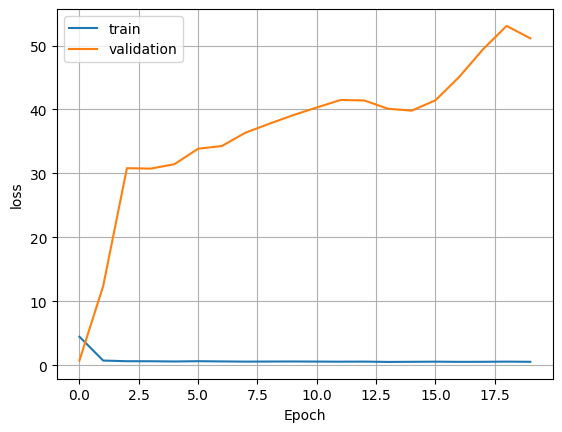

In [16]:
plot_loss(history)

https://stackoverflow.com/questions/60157742/convolutional-neural-network-cnn-input-shape
https://dataheadhunters.com/academy/encoding-categorical-data-one-hot-vs-label-encoding/
https://www.reddit.com/r/MLQuestions/comments/b00rvx/why_should_my_input_values_to_cnn_be_between_0/